In [1]:
import collections, gym, random, tqdm
import matplotlib.pyplot as mp
import numpy as np, torch as th
from torch.autograd import Variable
from scipy.signal import lfilter

![env](https://miro.medium.com/max/2244/1*cAezGWdRG9_3DXrKg3uftw.jpeg)

In [2]:
directional_actions ={0:[-1,0], # north
                      1:[0,1],  # east
                      2:[1,0],  # south
                      3:[0,-1]} # west

directional_labels = ['north','east','south','west']

### Environment

In [3]:
class CliffWalking(gym.Env):
    def __init__(self, tabular=False):
        super().__init__()
        self.fig,self.ax = mp.subplots()
        self.tabular = tabular
        self.state_space = 4*12
        self.action_space= (len(list(directional_actions)),)

        self.goal = np.array([3,11])
        
        self.cliff = [[3,i] for i in range(1,11)]
        self.walker = self.init = (3,0)

        self.timer,self.limit = 0,(4*12)*2

    def off_policy_action(self):
        return np.random.randint(0,3)

    def terminal_condition(self):
        if list(self.walker) in self.cliff:
            return -100,True,'failure'
        if tuple(self.walker) == tuple(self.goal):
            return 0,True,'success'
        return -1,False,'neutral'

    def fill(self):
        grid = np.zeros(shape=(4,12))
        grid[self.goal[0],self.goal[1]] = 2
        for x,y in self.cliff: grid[x,y] = -1
        grid[self.walker[0],self.walker[1]] = 1
        return grid

    def reset(self):
        self.timer = 0
        self.walker = self.init = (3, 0)
        if self.tabular: state = int(np.where(self.fill().flatten() == 1)[0])
        else: state = self.fill()
        return state

    def step(self, action):
        self.timer += 1
        metadata = {}

        action = directional_actions[action]

        prev = tuple(self.walker)
        self.walker = np.asarray(self.walker) + np.asarray(action)
        self.walker[0] = np.clip(self.walker[0],0,3)
        self.walker[1] = np.clip(self.walker[1],0,11)
        curr = tuple(self.walker)

        if self.tabular:
            state = int(np.where(self.fill().flatten() == 1)[0])
        else:
            state = self.fill()

        reward,terminal,status = self.terminal_condition()
        metadata['status'] = status
        return state, reward, terminal, metadata

### Experience Replay

In [4]:
class ExperienceReplay(object):
    def __init__(self, capacity=2**20):
        self.capacity = capacity
        self.buffer = collections.deque(maxlen=self.capacity)
        self.ordering = ['states','actions','rewards','sprimes','terminals']
    def retain(self, state, action, reward, sprime, terminal):
        s = np.asarray(state).astype(np.float32)
        a = np.asarray(action).astype(np.float32)
        r = np.asarray(reward).astype(np.float32)
        s_= np.asarray(sprime).astype(np.float32)
        t = np.asarray(terminal).astype(np.float32)
        self.buffer.append((s,a,r,s_,t))
    def wipe(self):
        self.buffer = collections.deque(maxlen=self.capacity)
    def minibatch(self, bsize=1):
        S,A,R,S_,T = self.sample(bsize)
        S = Variable(th.from_numpy(S).float())
        A = Variable(th.from_numpy(A).float())
        R = Variable(th.from_numpy(R).float())
        S_= Variable(th.from_numpy(S_).float())
        T = Variable(th.from_numpy(T).float())
        return S,A,R,S_,T
    def recent(self, bsize=1):
        s,a,r,s_,t = np.asarray(self.buffer)[-bsize,:]
        S = Variable(th.from_numpy(np.asarray(s)).float())
        A = Variable(th.from_numpy(np.asarray(a)).float()).view(1)
        R = Variable(th.from_numpy(np.asarray(r)).float()).view(1)
        S_= Variable(th.from_numpy(np.asarray(s_)).float())
        T = Variable(th.from_numpy(np.asarray(t)).float())
        return S,A,R,S_,T
    def sequence(self, axis='rewards'):
        return np.asarray(self.buffer)[:,self.ordering.index(axis)]
    def sample(self, bsize=1):
        s,a,r,s_,t = zip(*random.sample(self.buffer, bsize))
        return np.array(s), np.array(a), np.array(r), np.array(s_), np.array(t)
    def __len__(self):
        return len(self.buffer)

### ε-Greedy Policy

In [5]:
class EpsilonGreed(object):
    def __init__(self, epsilon_min=1e-2, epsilon_init=1.0, epsilon_decay=2**12):
        super().__init__()
        self.epsilon = self.epsilon_init = epsilon_init
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.calls = 0

    def decay_epsilon(self, itr):
        decay = np.exp(-1 * itr / self.epsilon_decay)
        self.epsilon = self.epsilon_min + (self.epsilon_init - self.epsilon_min) * decay
        return self.epsilon

    def __call__(self, logits):
        self.calls += 1
        if np.random.random() > self.epsilon:
            action = logits.max(dim=1)[1].item()
        else:
            action = np.random.randint(0,logits.size(dim=1))
        self.decay_epsilon(self.calls)
        return action

In [6]:
def simulate(sim, agent, episodes=1, render=False):
    success,failure,neutral = 0,0,0

    completed,cummulative,stats = [],[],[]
    bar = tqdm.tqdm_notebook(range(1,1+episodes))
   
    for episode in bar:
        state,returns,terminal = sim.reset(),[],False
        while not terminal and sim.timer < sim.limit:
            action = agent.interact(state)

            sprime, reward, terminal, metadata = sim.step(action)
            agent.memory.retain(state,action,reward,sprime,terminal)
            state = sprime
            returns.append(reward)

            loss = agent.update()
        
        cummulative.append(np.sum(returns))
        agent.memory.wipe()
        
        banner = '{}  Succ. Rate: {:.4f}, ε: {:.4f}'
        if metadata['status'] == 'success': icon,success = '👍',success+1
        if metadata['status'] == 'failure': icon,failure = '👎',failure+1
        if metadata['status'] == 'neutral': icon,neutral = '🤞',neutral+1
        succ_rate = success/(success+failure+neutral)
        banner = banner.format(icon, succ_rate, agent.policy.epsilon)
        bar.set_description(banner)

    success_rate = success / (success+failure)
    mp.title('Tabular Q-Learning, Success Rate: {}'.format(success_rate))
    mp.plot(lfilter([1.0 /25] * 25,1,cummulative),label='qlearn', color='darkcyan', lw=3)
    return cummulative,success_rate

### Tabular TD Agent

In [7]:
class TabularTD(object):
    def __init__(self, on_policy=False, states=48, actions=4):
        super().__init__()
        self.on_policy = on_policy
        self.states, self.actions = states, actions
        self.model = np.zeros((states,actions))
        self.policy= EpsilonGreed()
        self.memory = ExperienceReplay()

    def update(self, alpha=1, gamma=0.99):
        S,A,R,S_,T = self.memory.minibatch()

        S,A,S_= int(S),int(A),int(S_)
                
        Qvalue = th.from_numpy(np.asarray(self.model[S,A])).float().unsqueeze(0)

        if self.on_policy:
            logits = th.from_numpy(np.asarray(self.model[S_,:])).float().unsqueeze(0)
            A_ = self.policy(logits)
            Qprime = self.model[S_,A_]
            self.memory.wipe()
        else:
            Qprime = np.max(self.model[S_,:])

        self.model[S,A] = (1 - alpha) * Qvalue + alpha * (R + gamma * Qprime)
        return Qprime - Qvalue
    
    def interact(self, state, logits=False):
        Q = self.model[state,:]
        action = self.policy(th.from_numpy(Q).float().unsqueeze(0))
        if logits: return action, Q
        else: return action

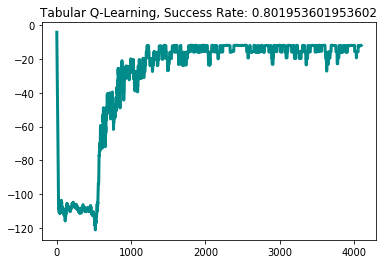

In [8]:
episodes = 2**12

agent = TabularTD(on_policy=False)
sim = CliffWalking(tabular=True)

returns,succ_rate = simulate(sim, agent, episodes=episodes)

In [9]:
heatmap = agent.model.reshape(4,12,4)
print(heatmap.shape)

(4, 12, 4)


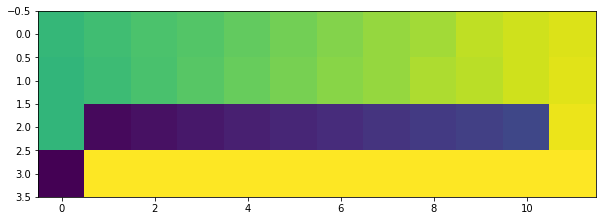

In [10]:
fig,ax = mp.subplots(1,1,figsize=(10,10))
ax.imshow(np.sum(heatmap,axis=-1))

In [11]:
np.sum(heatmap, axis=-1)

array([[ -45.44604874,  -41.8646965 ,  -38.24716949,  -36.4201355 ,
         -32.74761295,  -29.03799343,  -25.29090214,  -21.50596142,
         -18.63377857,  -12.85069871,   -9.92019987,   -6.97000003],
       [ -46.3324337 ,  -42.76003456,  -39.15155125,  -35.5066185 ,
         -31.82486868,  -28.10592794,  -24.34942198,  -21.50596142,
         -16.72219205,  -13.82099771,   -9.92019987,   -5.98000002],
       [ -46.32348061, -132.28481674, -129.58062363, -126.84911585,
        -124.09001637, -121.30304766, -118.48792648, -115.64436984,
        -112.77209044, -109.87079787, -106.94019985,   -3.99000001],
       [-135.85730648,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ]])